# Predict auction price

Try several models and improve predicition accuracy

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns

In [2]:
matplotlib.rcParams['font.sans-serif'] = ['Helvetica','Arial', 'sans-serif']
matplotlib.rcParams['axes.titlesize'] = 24
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 24
matplotlib.rcParams['ytick.labelsize'] = 24
matplotlib.rcParams['figure.titlesize'] = 24
matplotlib.rcParams['font.size'] = 18

In [3]:
fn = '../data/cars-for-ml.pkl'
print(fn)
df = pd.read_pickle(fn)
print(df.columns)

# cetegories
cat_columns = ['brand', 'model', 'fuel', 'body_type','color']
print(list(df[cat_columns]))


../data/cars-for-ml.pkl
Index(['price', 'brand', 'model', 'age', 'fuel', 'odometer',
       'days_since_inspection_invalid', 'age_at_import', 'body_type',
       'displacement', 'number_of_cylinders', 'power', 'power2', 'weight',
       'registration_tax', 'sale_price', 'number_of_seats', 'number_of_doors',
       'color'],
      dtype='object')
['brand', 'model', 'fuel', 'body_type', 'color']


In [4]:
models = dict()

- - - - - 
# Model 1: Simple linear fit
Regress age (in days) with price (euro).  
!! Use all data, do not split train and test. !!   
!! Accuracy is based on data that was used for fit. !!

## Prepare input

In [5]:
from sklearn import linear_model

model_name = 'linear regression no cv'
betas = list()

X = df.dropna(subset=['price','age']).age.values.reshape(-1,1)
y = df.dropna(subset=['price','age']).price.values.reshape(-1,1)
print(X.shape)
print(y.shape)

(2883, 1)
(2883, 1)


## Fit

In [6]:
models[model_name] = dict()

# create regression model object and store
reg = linear_model.LinearRegression()
models[model_name].update({'model':reg})

# fit
reg.fit(X,y)
models[model_name].update({'n':y.shape[0]})

# parameters
betas.append([*reg.intercept_, *reg.coef_[0]])
models[model_name].update({'betas':betas})

# score
models[model_name].update({'R^2':reg.score(X,y)})

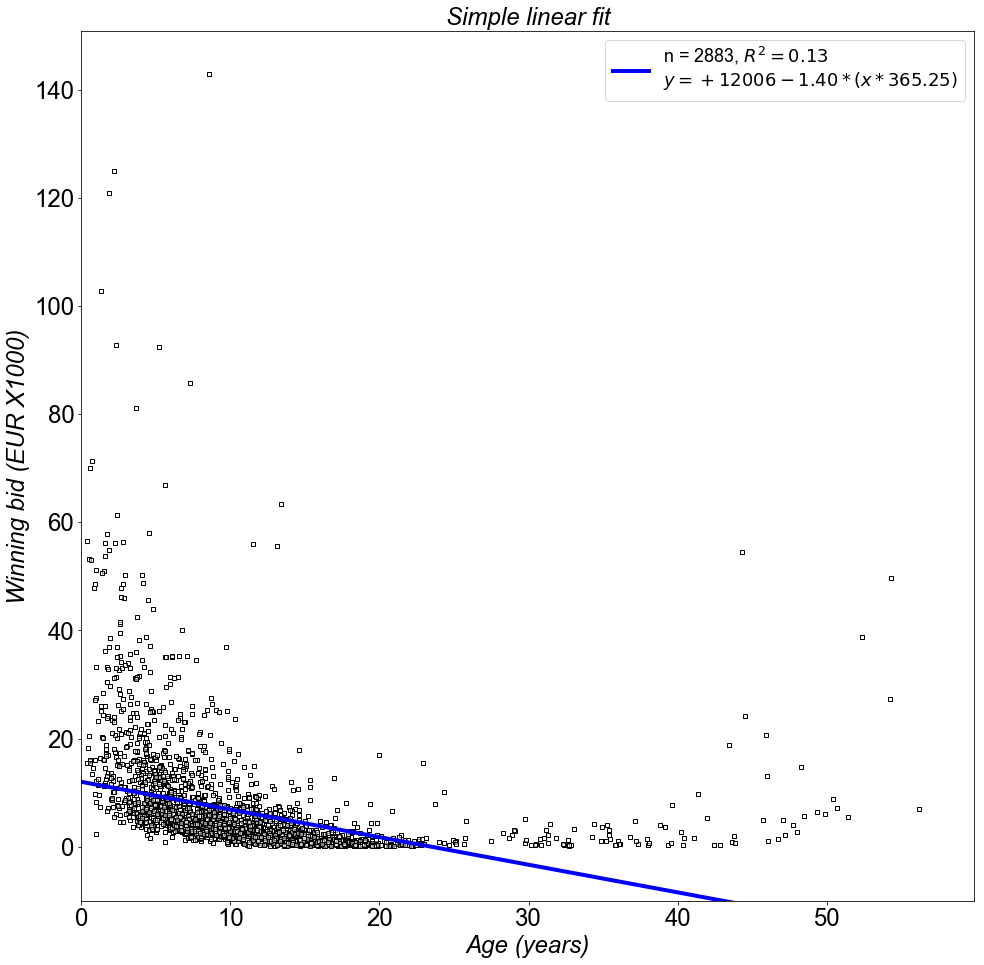

In [7]:
# Fit a line by using predict
prediction_X = pd.np.array([0,int(pd.np.ceil(X.max()/365.25))*365.25]).reshape(-1,1)
prediction_y = reg.predict(prediction_X)

# plot
plt.figure(figsize=[16,16])
plt.plot(X/365.25, y/1000, marker='s', markeredgecolor = (0, 0, 0, 1), markerfacecolor = (1, 1, 1, .5), linestyle='None', ms=4)
hdl_fit = plt.plot(prediction_X/365, prediction_y/1000, color='blue', marker=None, linestyle='-', linewidth=4)
plt.legend(hdl_fit, ['n = {}, $R^2 = {:.2f}$\n$y = {:+.0f}{:+.2f}*(x*365.25)$'.format(
    models[model_name]['n'],
    models[model_name]['R^2'],
    *models[model_name]['betas'][-1]
)], loc='upper right')
plt.xlabel('Age (years)', style='italic')
plt.ylabel('Winning bid (EUR X1000)', style='italic')
plt.title('Simple linear fit', style='italic')
plt.ylim(bottom = -10)
plt.xlim(left = 0)

plt.savefig('../results/{}.png'.format(model_name.replace(' ','_')), bbox_inches='tight', transparent=True)

## Model 2: linear but with scaled dependent values (prices)

Prices are log transformed.  
Also use cross validation.

## Prepare input

In [8]:
from sklearn.model_selection import train_test_split, cross_val_score

model_name = 'linear regression log price'
betas = list()

X = df.dropna(subset=['price','age']).age.values.reshape(-1,1)
y = pd.np.log10(df.dropna(subset=['price','age']).price.values.reshape(-1,1))
print(X.shape)
print(y.shape)

(2883, 1)
(2883, 1)


## Fit

In [9]:
models[model_name] = dict()

# split train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

# create regression model object and store
reg = linear_model.LinearRegression()
models[model_name].update({'model':reg})

# fit
reg.fit(X,y)
models[model_name].update({'n':y.shape[0]})

# parameters
betas.append([*reg.intercept_, *reg.coef_[0]])
models[model_name].update({'betas':betas})

# score
models[model_name].update({'R^2':reg.score(X,y)})
models[model_name].update({'test R^2':reg.score(X_test,y_test)})
cv_results = cross_val_score(reg, X_test, y_test, cv=5)
models[model_name].update({'cv R^2':cv_results})


(2018, 1)
(865, 1)


In [10]:
models[model_name]

{'model': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 'n': 2883,
 'betas': [[3.9507165604878, -0.00011678219203395447]],
 'R^2': 0.30569144054471076,
 'test R^2': 0.33373326767373923,
 'cv R^2': array([0.47927357, 0.37070065, 0.18093918, 0.35166769, 0.18225771])}

In [11]:
depr_half_n_days = -(pd.np.log10(2)/models[model_name]['betas'][0][1])
depr_half_n_days / 365.25
depr_half_n_days
print('Car depreciates to half its value every\n\t{:.0f} days ({:.1f} years).'.format(depr_half_n_days, depr_half_n_days/365.25))
for y in [0,2,4,6,8]:
    print('y(t={:+5.0f}) = {:.0f} euro'.format(y, 10**reg.predict([[y*365.25]])[0][0]))
print('y(t={:+5.1f}) = {:.0f} euro'.format(depr_half_n_days/365.25, 10**reg.predict([[depr_half_n_days]])[0][0]))
print('y(t=0) / 2 = {:.0f} euro'.format(10**models[model_name]['betas'][0][0]/2))

Car depreciates to half its value every
	2578 days (7.1 years).
y(t=   +0) = 8927 euro
y(t=   +2) = 7335 euro
y(t=   +4) = 6027 euro
y(t=   +6) = 4952 euro
y(t=   +8) = 4069 euro
y(t= +7.1) = 4464 euro
y(t=0) / 2 = 4464 euro


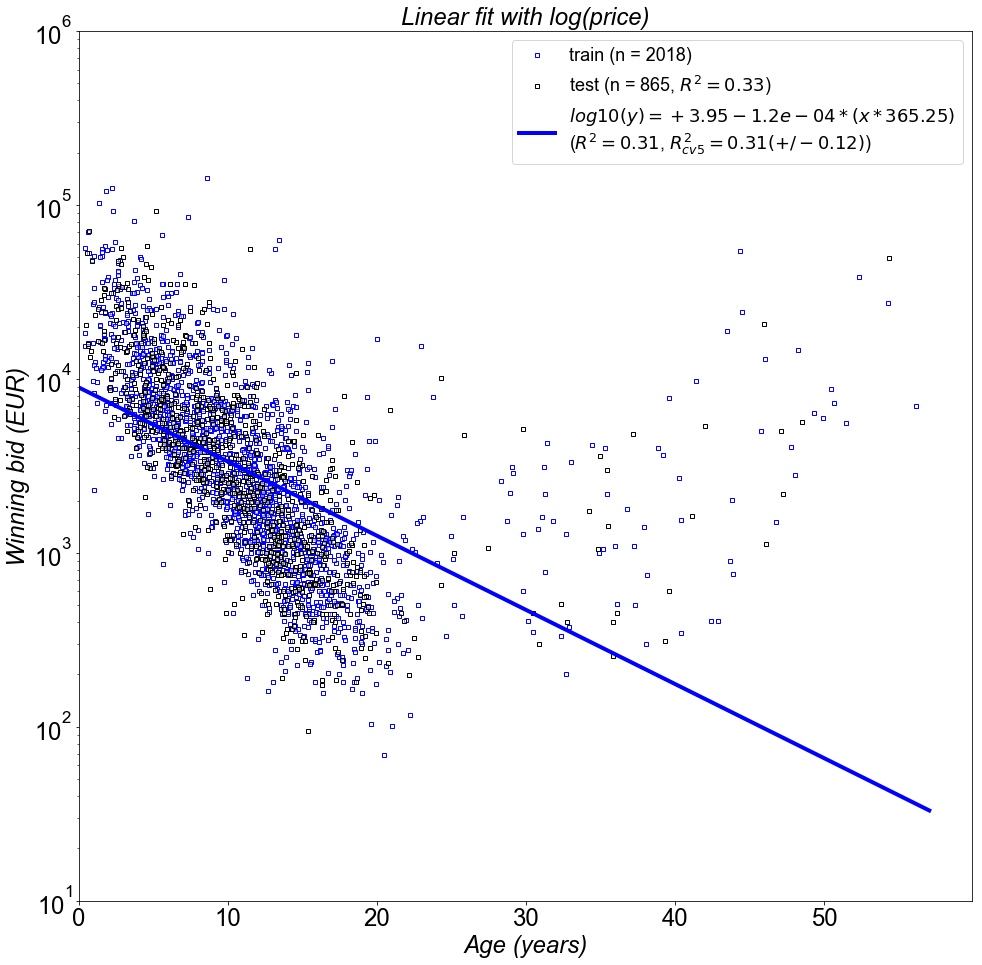

In [12]:
# Fit a line by using predict
prediction_X = pd.np.array([0,int(pd.np.ceil(X.max()/365.25))*365.25]).reshape(-1,1)
prediction_y = reg.predict(prediction_X)

# plot
plt.figure(figsize=[16,16])
hdl_trn = plt.plot(X_train/365.25, pd.np.power(10,y_train), marker='s', markeredgecolor = (0, 0, 1, 1), markerfacecolor = (1, 1, 1, .5), linestyle='None', ms=4, 
                   label='train (n = {})'.format(y_train.shape[0]))
hdl_tst = plt.plot(X_test/365.25, pd.np.power(10,y_test), marker='s', markeredgecolor = (0, 0, 0, 1), markerfacecolor = (1, 1, 1, .5), linestyle='None', ms=4, 
                   label='test (n = {}, $R^2 = {:.2f}$)'.format(
                       y_test.shape[0],
                       models[model_name]['test R^2'],
                   ))
hdl_fit = plt.plot(prediction_X/365, pd.np.power(10,prediction_y), color='blue', marker=None, linestyle='-', linewidth=4, 
                   label = '$log10(y) = {:+.2f}{:+.1e}*(x*365.25)$\n($R^2 = {:.2f}$, $R^2_{{cv{:g}}} = {:.2f} (+/-{:.2f})$)'.format(
                       *models[model_name]['betas'][-1],
                       models[model_name]['R^2'],
                       models[model_name]['cv R^2'].shape[0],
                       pd.np.mean(models[model_name]['cv R^2']),
                       pd.np.std(models[model_name]['cv R^2']),
                   ))
plt.legend()
plt.xlabel('Age (years)', style='italic')
plt.ylabel('Winning bid (EUR)', style='italic')
plt.title('Linear fit with log(price)', style='italic')
plt.ylim(bottom = 10, top = 1000000)
plt.xlim(left = 0)
plt.yscale('log')

plt.savefig('../results/{}.png'.format(model_name.replace(' ','_')), bbox_inches='tight', transparent=True)